# Using K-means to determine if penguins of the same species exhibit different physical characteristics based on sex.

#### Overview:
Purpose: Determine if penguins of the same species exhibit different physical characteristics based on sex.

**Part 1:** EDA & Data Preparation
- Data Loading
- Initial Exploration
- Univariate Analysis
- Data Cleaning and Scaling/Transformation

**Part 2:** Model Building and Evaluation
- Fit Model
- Evaluations:
    - Inertia/Multiple k values
    - Silouhette Scores, Elbow Plot

**Part 3:** Interpreting Model Results
- Cluster Analysis
- Utilizing Cluster Partitions for Quantitative Analysis

**Part 4:** Conclusion/Summary

### **Change Log**

- 2022_0315, S. Souto, Initial Version
- 2024_0502, S. Souto, Updated format to match portfolio format

### **Data Sources**

1. Original data: Seaborn's "penguins.csv"

### **Notebook Setup**

In [1]:
# Import packages and libraries
import numpy as np
import pandas as pd

# Packages for visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Packages for date conversions

# Packages for modeling and evaluation
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [2]:
# Notebook setup
pd.set_option('display.max_columns', None)

# Suppress warnings
# Fitting K-means model results in: "UserWarning: KMeans is known to have a memory leak on Windows with MKL" 
# Since memory leak will be small for this notebook, suppressing the warning instead of changing system environment variable for OMP_NUM_THREADS.
import warnings
warnings.filterwarnings('ignore')

## **Part 1:** EDA & Data Preparation

### Data Loading

In [3]:
# Load dataset into dataframe, save copy
df0 = pd.read_csv('data/penguins.csv')
penguins = df0.copy()

In [4]:
penguins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [5]:
penguins.shape

(344, 7)

In [6]:
penguins.head(10)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male
6,Adelie,Torgersen,38.9,17.8,181.0,3625.0,female
7,Adelie,Torgersen,39.2,19.6,195.0,4675.0,male
8,Adelie,Torgersen,34.1,18.1,193.0,3475.0,NaN
9,Adelie,Torgersen,42.0,20.2,190.0,4250.0,NaN


### Initial Exploration

#### Check for missing, duplicate data

In [7]:
# Check for duplicates
print('Shape of dataframe:', penguins.shape)
print('Shape of dataframe with duplicates dropped:', penguins.drop_duplicates().shape)

Shape of dataframe: (344, 7)
Shape of dataframe with duplicates dropped: (344, 7)


In [8]:
# Check for missing values
print('Total count of missing values:', penguins.isna().sum().sum())

Total count of missing values: 19


In [9]:
# Display missing values per column in dataframe
print('Missing values per column:')
penguins.isna().sum()

Missing values per column:


species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

There are 344 observations and 7 features (dimensions) in the penguins dataset.  
- There are missing values to handle - an assumption of K-means is that there are no missing values.
- There are textual values in the data.  K-means requires numeric columns for clustering.  Encoding will be required.

#### Summary Statistics

In [10]:
# Display descriptive stats
penguins.describe(include='all')

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
count,344,344,342.000000,342.000000,342.000000,342.000000,333
unique,3,3,NaN,NaN,NaN,NaN,2
top,Adelie,Biscoe,NaN,NaN,NaN,NaN,male
freq,152,168,NaN,NaN,NaN,NaN,168
mean,NaN,NaN,43.921930,17.151170,200.915205,4201.754386,NaN
std,NaN,NaN,5.459584,1.974793,14.061714,801.954536,NaN
min,NaN,NaN,32.100000,13.100000,172.000000,2700.000000,NaN
25%,NaN,NaN,39.225000,15.600000,190.000000,3550.000000,NaN
50%,NaN,NaN,44.450000,17.300000,197.000000,4050.000000,NaN
75%,NaN,NaN,48.500000,18.700000,213.000000,4750.000000,NaN


### Univariate Analysis

In [11]:
# individual penguins types
penguins['species'].value_counts(dropna = False)

species
Adelie       152
Gentoo       124
Chinstrap     68
Name: count, dtype: int64

In [12]:
# individual geographic types
penguins['island'].value_counts(dropna = False)

island
Biscoe       168
Dream        124
Torgersen     52
Name: count, dtype: int64

In [13]:
# individual genders
penguins['sex'].value_counts(dropna = False)

sex
male      168
female    165
NaN        11
Name: count, dtype: int64

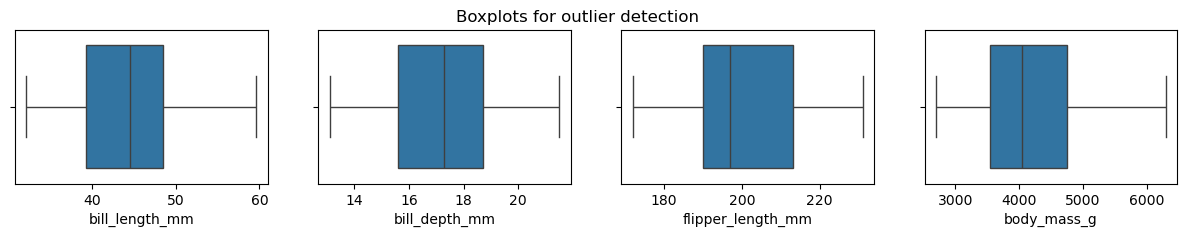

In [14]:
## Box plot for each measurement
fig, axes = plt.subplots(1, 4, figsize=(15, 2))
fig.suptitle('Boxplots for outlier detection')
sns.boxplot(ax=axes[0], x=penguins['bill_length_mm'])
sns.boxplot(ax=axes[1], x=penguins['bill_depth_mm'])
sns.boxplot(ax=axes[2], x=penguins['flipper_length_mm'])
sns.boxplot(ax=axes[3], x=penguins['body_mass_g'])
plt.show();

No outliers exist.  As a well-established dataset from Seaborn, we anticipate minimal data cleaning and outlier detection.

### Data Cleaning and Transformation

In [15]:
#drop the rows with the missing values from the `sex` column
penguins_subset = penguins.dropna(axis=0).reset_index(drop = True)
penguins_subset.isna().sum()

species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

In [16]:
penguins_subset.head(10)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female
3,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female
4,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male
5,Adelie,Torgersen,38.9,17.8,181.0,3625.0,female
6,Adelie,Torgersen,39.2,19.6,195.0,4675.0,male
7,Adelie,Torgersen,41.1,17.6,182.0,3200.0,female
8,Adelie,Torgersen,38.6,21.2,191.0,3800.0,male
9,Adelie,Torgersen,34.6,21.1,198.0,4400.0,male


#### Encode Data

Convert only the categorical column `sex` into numeric. 

In [17]:
# Convert column `sex` from categorical to numeric
# Note that it is not hierarchical data, therefore creating dummies
penguins_subset = pd.get_dummies(penguins_subset, drop_first = True, columns=['sex'])

#### Drop Columns

Remove the 'island' column as it's irrelevant to comparing penguins of the same species and their physical characteristics by sex.

In [18]:
penguins_subset = penguins_subset.drop(['island'], axis=1)

In [19]:
penguins_subset.head(10)

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex_male
0,Adelie,39.1,18.7,181.0,3750.0,True
1,Adelie,39.5,17.4,186.0,3800.0,False
2,Adelie,40.3,18.0,195.0,3250.0,False
3,Adelie,36.7,19.3,193.0,3450.0,False
4,Adelie,39.3,20.6,190.0,3650.0,True
5,Adelie,38.9,17.8,181.0,3625.0,False
6,Adelie,39.2,19.6,195.0,4675.0,True
7,Adelie,41.1,17.6,182.0,3200.0,False
8,Adelie,38.6,21.2,191.0,3800.0,True
9,Adelie,34.6,21.1,198.0,4400.0,True


**Note:** Because the species column isn't a feature, it doesn't need to be scaled. 
Copy all features except `species` to a DataFrame `X` 

In [20]:
# Exclude `species` variable from X
X = penguins_subset.drop(['species'], axis=1)

#### Scale the Features

Because K-means uses distance between observations as its measure of similarity, it's important to scale the data before modeling.

In [21]:
# Scale the features
X_scaled = StandardScaler().fit_transform(X)

## **Part 2:** Model Building and Evaluation

#### Fit K-means and evaluate inertia for different values of k


While we may have a preliminary estimate of the optimal cluster number, this is not always definitive. To account for this uncertainty, it's prudent to experiment with a range of cluster values and assess the results.

In [22]:
# Create function to fit for a range of cluster values and return a list of each k-values inertia
def kmeans_inertia(num_clusters, x_vals):
    """
    Accepts as arguments list of ints and data array. 
    Fits a KMeans model where k = each value in the list of ints. 
    Returns each k-value's inertia appended to a list.
    """
    inertia = []
    for num in num_clusters:
        kms = KMeans(n_clusters=num, random_state=42)
        kms.fit(x_vals)
        inertia.append(kms.inertia_)

    return inertia

##### Fit the models to the scaled data for a range of clusters to retrieve inertias

In [23]:
# Return a list of inertia for k=2 to 10.
num_clusters = [i for i in range(2, 11)]
inertia = kmeans_inertia(num_clusters, X_scaled)
inertia

[885.622414365225,
 578.8284278107235,
 477.22956735281946,
 284.5464837898288,
 218.05156297830223,
 201.51585567445812,
 196.58908645819537,
 180.65751845628574,
 170.15703589755498]

##### Plot the relationship between `num_clusters` and `inertia`

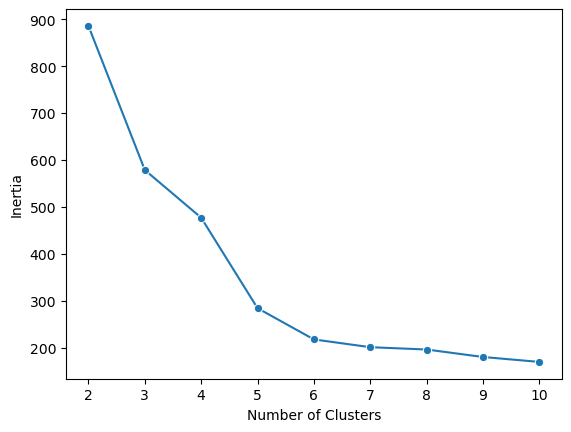

In [24]:
# Create a line plot.
plot = sns.lineplot(x=num_clusters, y=inertia, marker = 'o')
plot.set_xlabel("Number of Clusters");
plot.set_ylabel("Inertia");

While the elbow method hints at six clusters as an optimal number, we lack definitive proof. Silhouette analysis will provide a more reliable assessment.

##### Evaluate Silhouette Scores

Determine the distance between clusters by getting the silhouette score for each value of k used in the range, 2-10.

Create a function to return the silhouette scores of each in X_scaled:

In [25]:
# Create function to return a list of each k-value's score
def kmeans_sil(num_clusters, x_vals):
    """
    Accepts as arguments list of ints and data array. 
    Fits a KMeans model where k = each value in the list of ints.
    Calculates a silhouette score for each k value. 
    Returns each k-value's silhouette score appended to a list.
    """
    sil_score = []
    for num in num_clusters:
        kms = KMeans(n_clusters=num, random_state=42)
        kms.fit(x_vals)
        sil_score.append(silhouette_score(x_vals, kms.labels_))

    return sil_score

Get scores for the range

In [26]:
sil_scores = kmeans_sil(num_clusters, X_scaled)
sil_scores

[0.44398088353055243,
 0.45101024097188364,
 0.4489699212061027,
 0.519998574860868,
 0.5223086008347773,
 0.47386350642293157,
 0.4715443426463867,
 0.4160561489496056,
 0.418306343369105]

##### Plot the relationship between num_clusters and sil_score

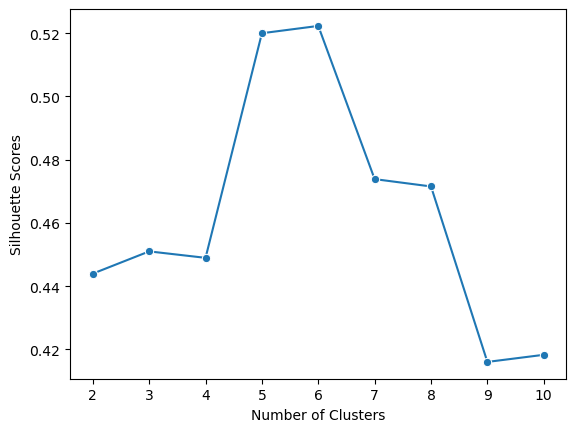

In [27]:
# Create a line plot.
plot = sns.lineplot(x=num_clusters, y=sil_scores, marker = 'o')
plot.set_xlabel("Number of Clusters");
plot.set_ylabel("Silhouette Scores");

A high silhouette score means a data point is well-separated from other clusters, while a low score indicates it's close to the boundary between clusters.  

The optimal number of clusters appears to be six based on the silhouette score, although a five-cluster solution is also a strong contender.

In [28]:
# Fit a six-cluster model
kmeans6 = KMeans(n_clusters=6, random_state=42)
kmeans6.fit(X_scaled)

KMeans(n_clusters=6, random_state=42)

Print out the unique labels of the fit model:

In [29]:
# Print unique labels
print('Unique labels:', np.unique(kmeans6.labels_))

Unique labels: [0 1 2 3 4 5]


## **Part 3:** Interpreting Model Results

### Cluster Analysis

We need to figure out what each cluster means and if the groups make sense.

- Create new column `cluster` to indicate the cluster assignment using original dataframe
- Group the cluster assignments to identify characteristics

In [30]:
# Create new column `cluster` from kmeans6.labels_ array
penguins_subset['cluster'] = kmeans6.labels_
penguins_subset.head()

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex_male,cluster
0,Adelie,39.1,18.7,181.0,3750.0,True,5
1,Adelie,39.5,17.4,186.0,3800.0,False,2
2,Adelie,40.3,18.0,195.0,3250.0,False,2
3,Adelie,36.7,19.3,193.0,3450.0,False,2
4,Adelie,39.3,20.6,190.0,3650.0,True,5


In [31]:
# Verify if any `cluster` can be differentiated by `species`
penguins_subset.groupby(by=['cluster', 'species']).size()

cluster  species  
0        Chinstrap    32
1        Gentoo       58
2        Adelie       73
         Chinstrap     2
3        Adelie        2
         Chinstrap    34
4        Gentoo       61
5        Adelie       71
dtype: int64

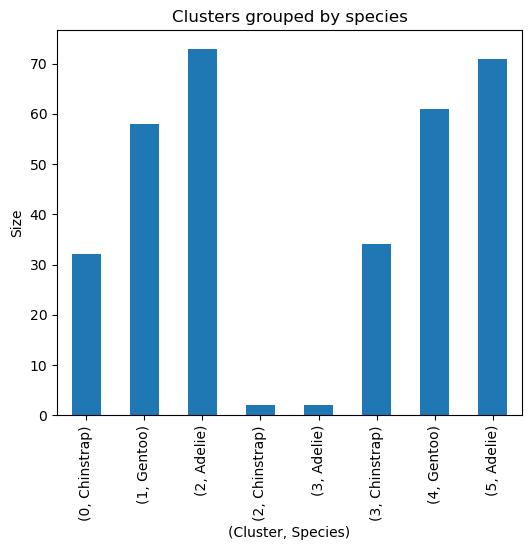

In [32]:
penguins_subset.groupby(by=['cluster', 'species']).size().plot.bar(title='Clusters grouped by species',
                                                                   figsize=(6, 5),
                                                                   ylabel='Size',
                                                                   xlabel='(Cluster, Species)');

There is overlap between species across multiple clusters, indicating that there is additional categorization.

In [33]:
# Verify if each `cluster` can be differentiated by `species` AND `sex_male`.
penguins_subset.groupby(by=['cluster','species', 'sex_male']).size().sort_values(ascending = False)

cluster  species    sex_male
2        Adelie     False       73
5        Adelie     True        71
4        Gentoo     True        61
1        Gentoo     False       58
3        Chinstrap  True        34
0        Chinstrap  False       32
2        Chinstrap  False        2
3        Adelie     True         2
dtype: int64

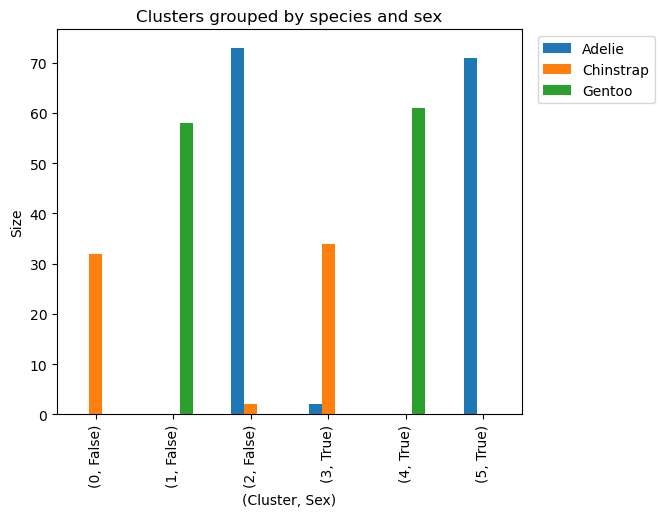

In [34]:
#Plot the clusters
penguins_subset.groupby(by=['cluster','species','sex_male']).size().unstack(level = 'species', fill_value=0).plot.bar(title='Clusters grouped by species and sex',
                                                                                                                      figsize=(6, 5),
                                                                                                                      ylabel='Size',
                                                                                                                      xlabel='(Cluster, Sex)')
plt.legend(bbox_to_anchor=(1.3, 1.0))

 The emergence of six clusters aligns with the expectation of three species and two sexes (3 * 2 = 6), suggesting that the clustering primarily distinguishes between species within each gender. To understand these gender-based differences, we will create scatterplots of the features.

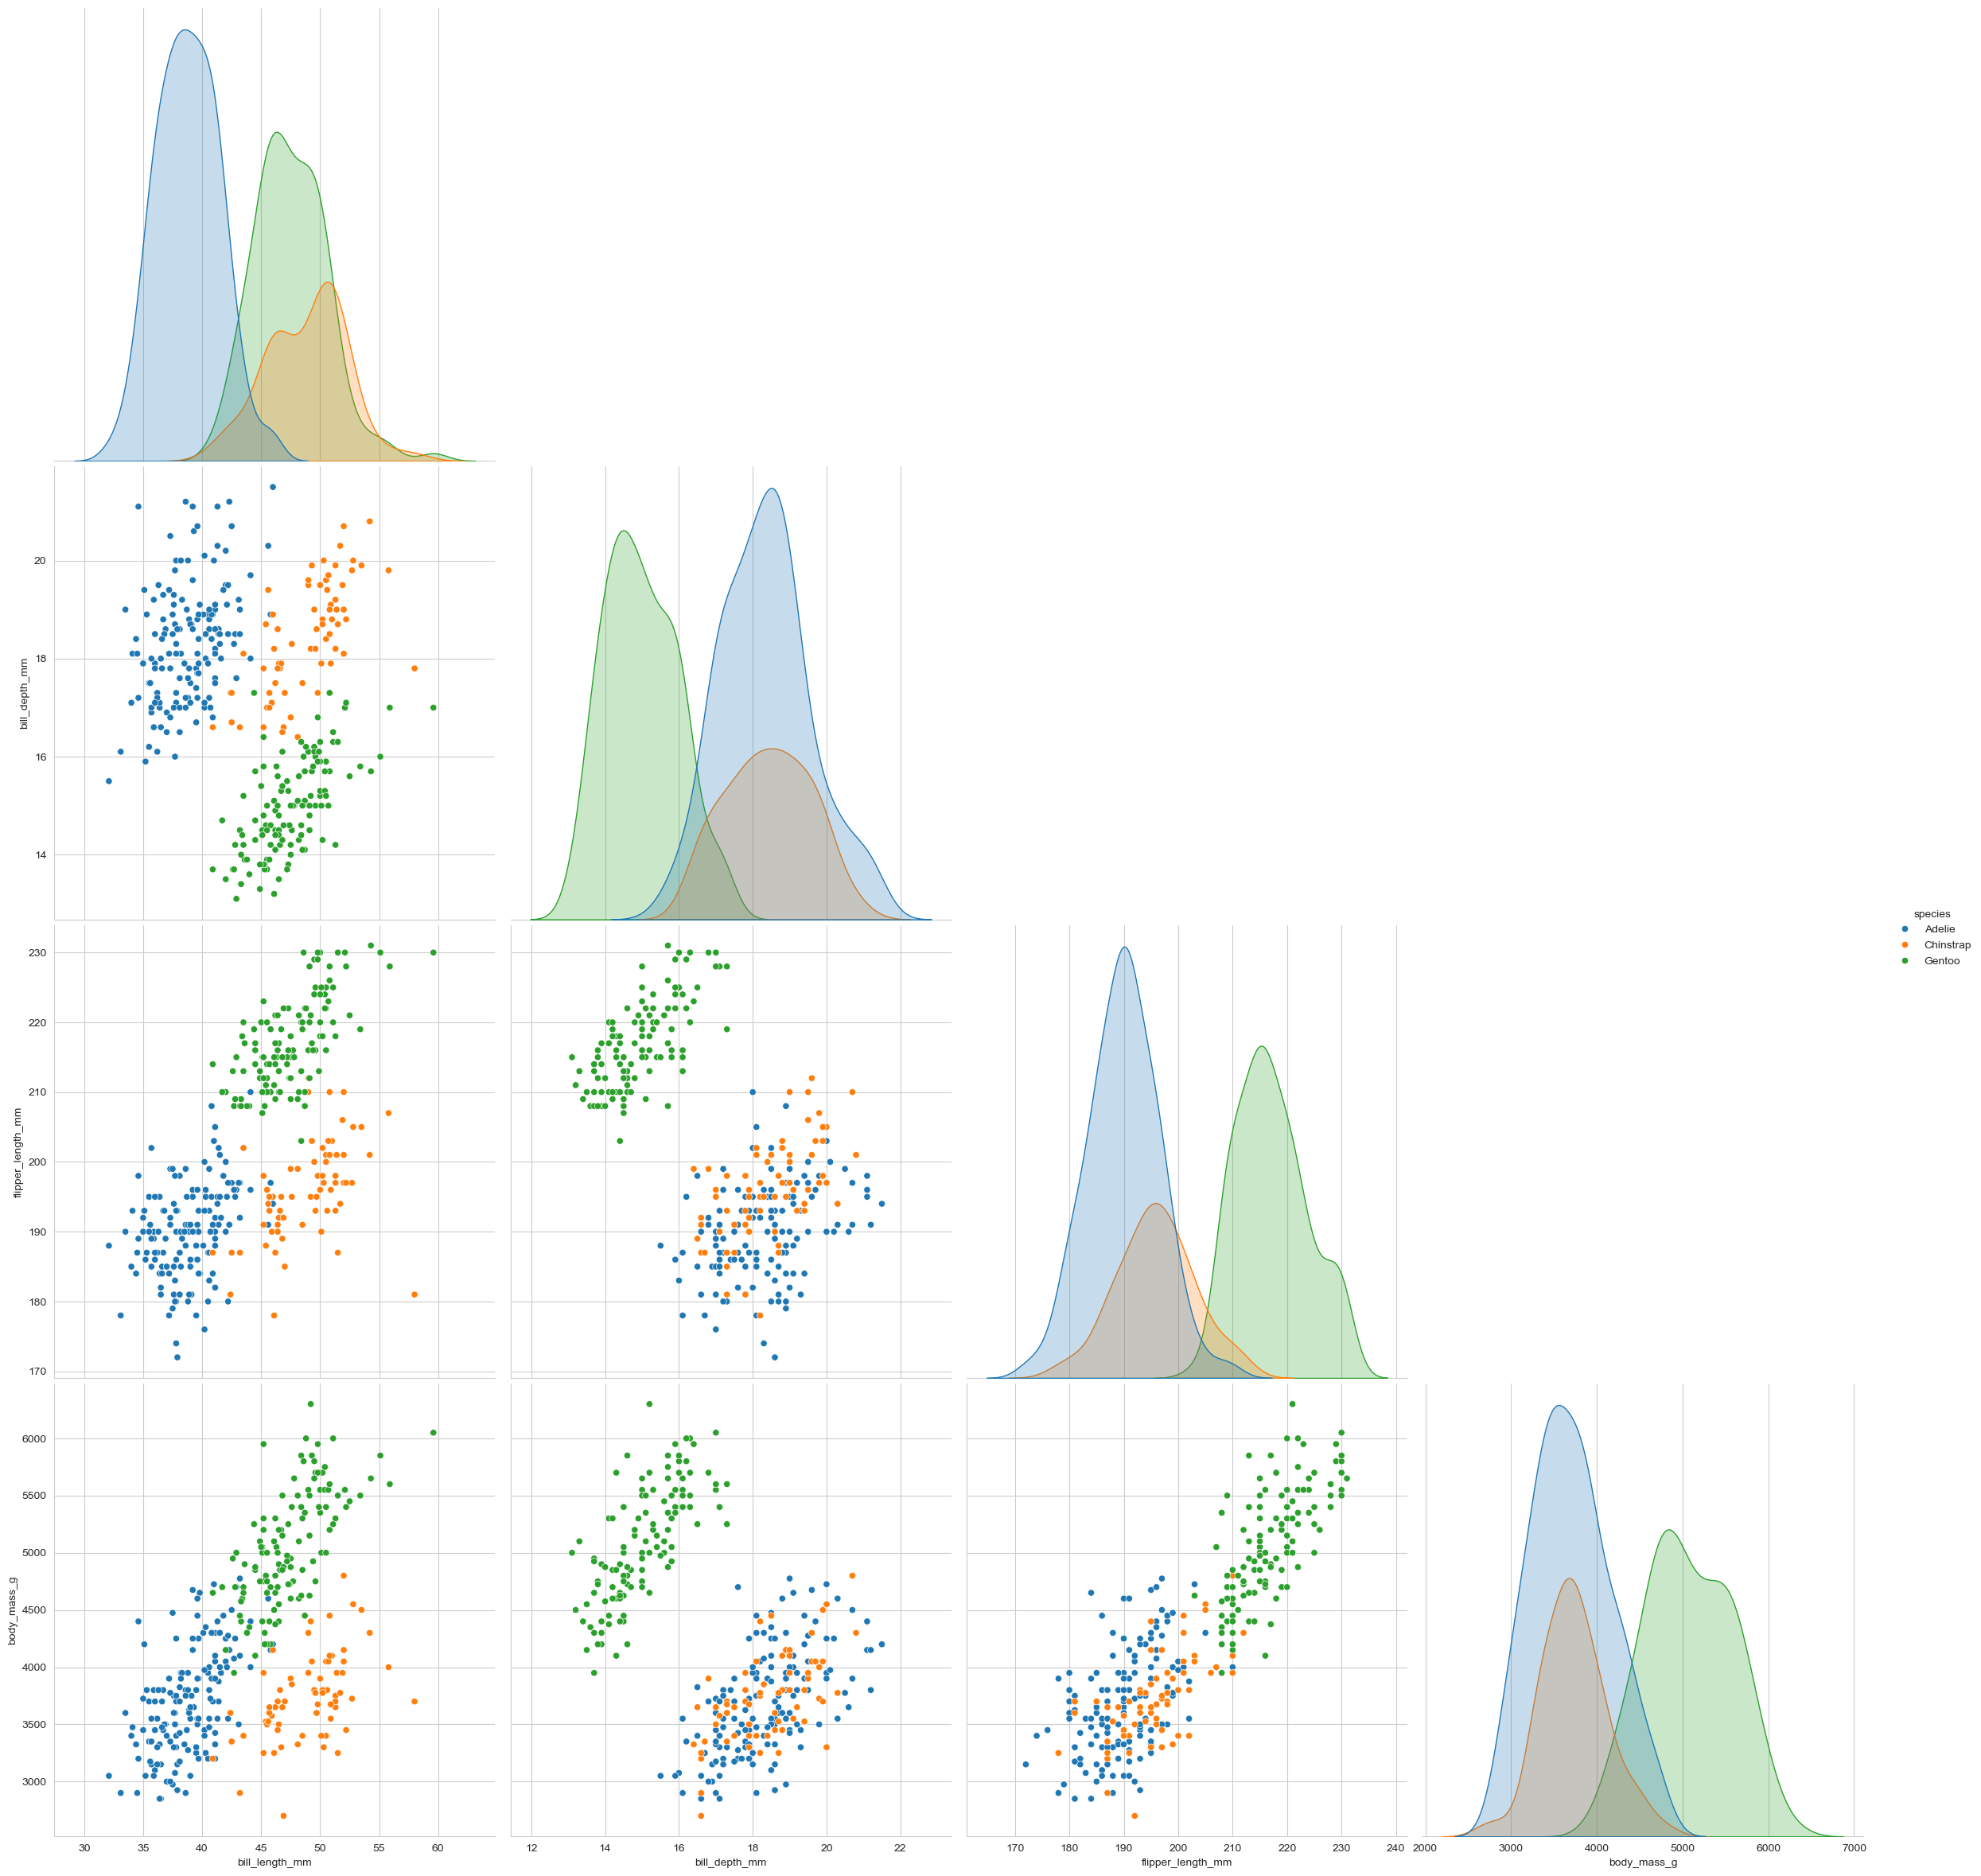

In [35]:
sns.set_style("whitegrid")
sns_plot = sns.pairplot(penguins,hue="species",size=6, corner=True)

#save the plot
sns_plot.figure.savefig("images/penguins_pairplot_species.png")
plt.show()

The correlation between `bill_length_mm` and each measurement feature reveals the clearest distinction separating the three species groups.

Let's break it down further by looking at sex:

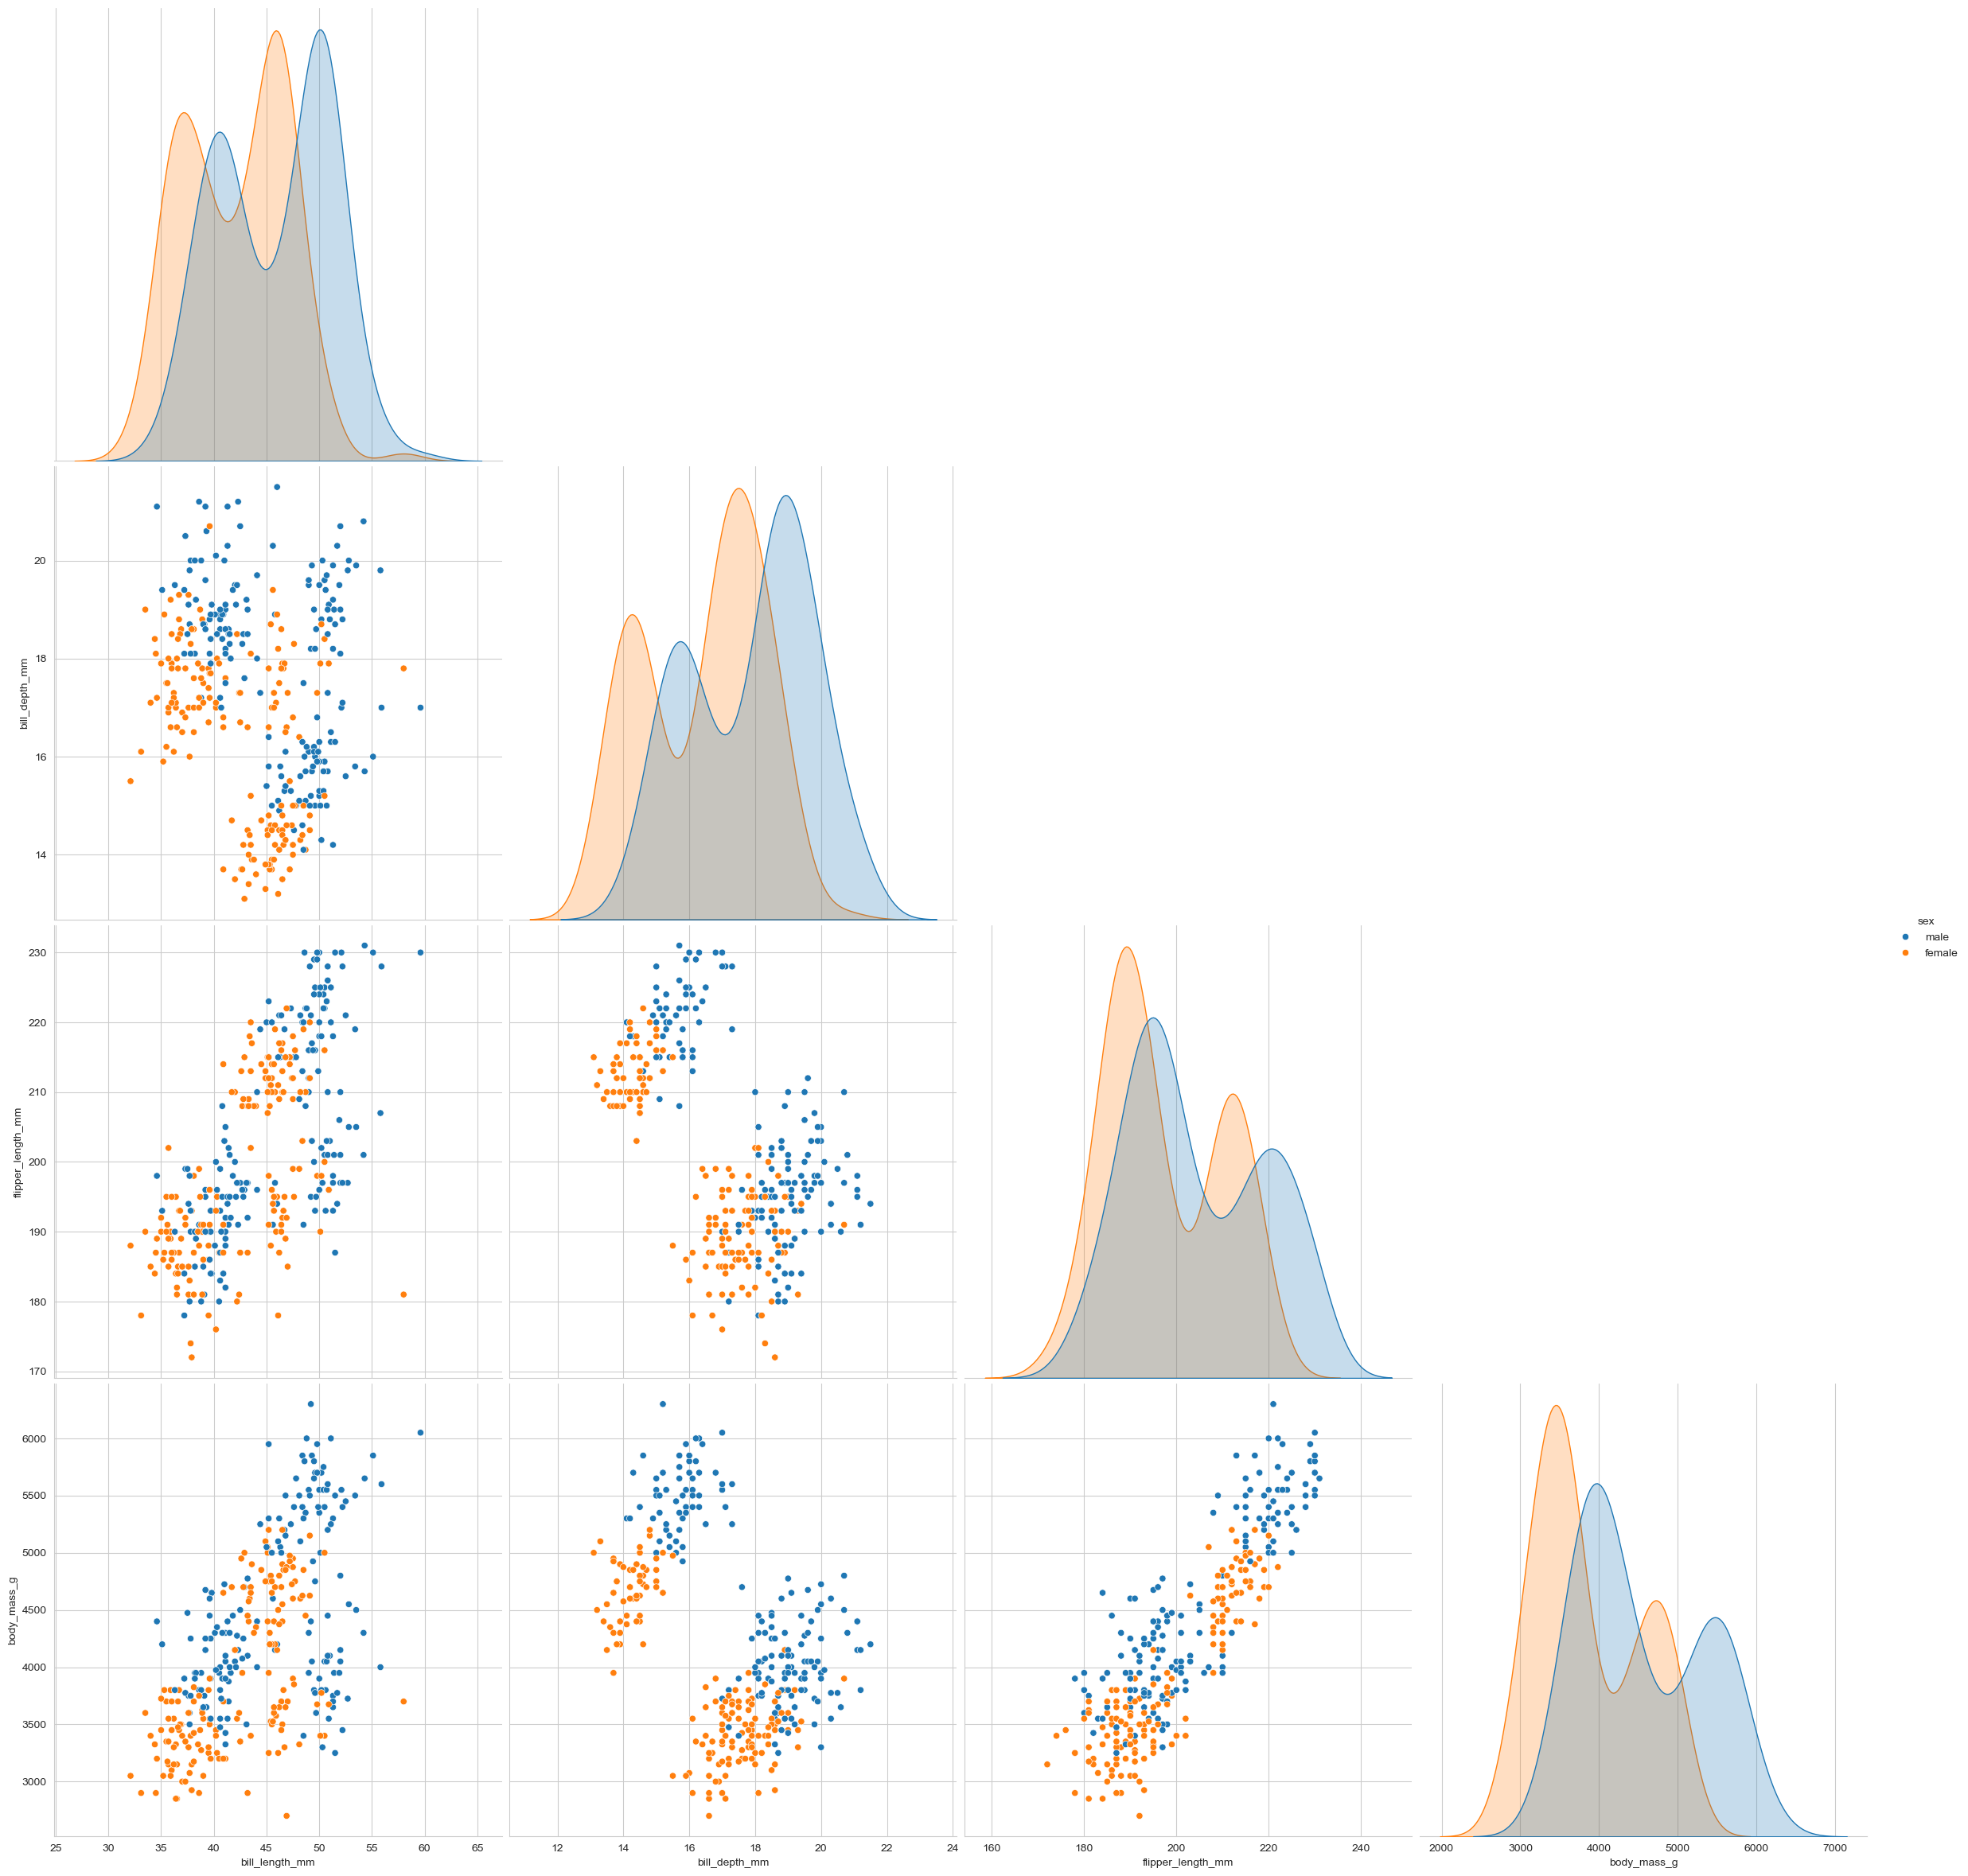

In [36]:
sns.set_style("whitegrid")
sns_plot = sns.pairplot(penguins,hue="sex",size=6, corner=True)

#save the plot
sns_plot.figure.savefig("images/penguins_pairplot_sex.png")
plt.show()

These same correlations are clearly differentiated by gender within each species.

The observed differentiation between sexes and species provides insight into the model's clustering decisions.

#### Cluster Characteristics

In [37]:
# Grouping by cluster and calculating mean values
cluster_means = penguins_subset.groupby(['cluster'])[['bill_length_mm', 
                                                    'bill_depth_mm',
                                                    'flipper_length_mm',
                                                   'body_mass_g']].mean()

print(cluster_means)

         bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g
cluster                                                               
0             46.881250      17.628125         192.218750  3535.156250
1             45.563793      14.237931         212.706897  4679.741379
2             37.374667      17.604000         187.693333  3369.666667
3             50.805556      19.305556         199.666667  3952.083333
4             49.473770      15.718033         221.540984  5484.836066
5             40.235211      19.040845         192.323944  4039.788732


##### Visualizing cluster characteristics

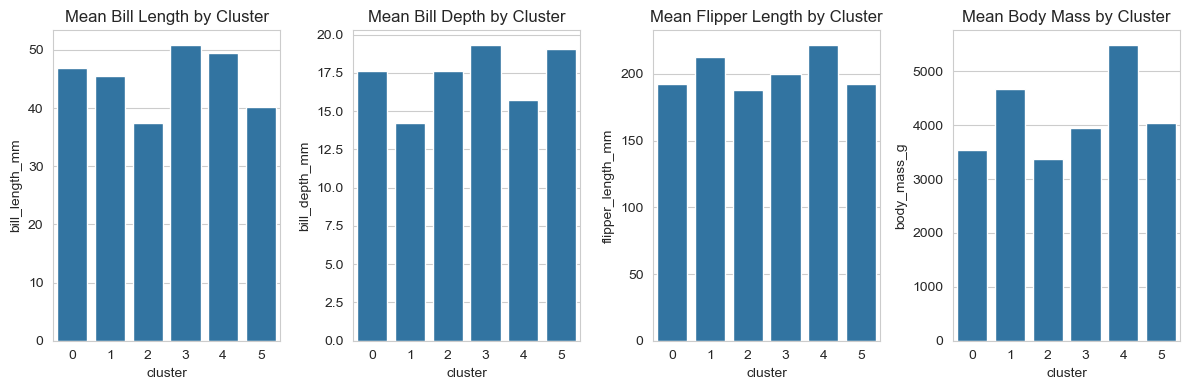

In [38]:
# Visualizing cluster characteristics
fig, axes = plt.subplots(1, 4, figsize=(12, 4))

sns.barplot(x=cluster_means.index, y='bill_length_mm', data=cluster_means, ax=axes[0])
axes[0].set_title('Mean Bill Length by Cluster')

sns.barplot(x=cluster_means.index, y='bill_depth_mm', data=cluster_means, ax=axes[1])
axes[1].set_title('Mean Bill Depth by Cluster')

sns.barplot(x=cluster_means.index, y='flipper_length_mm', data=cluster_means, ax=axes[2])
axes[2].set_title('Mean Flipper Length by Cluster')

sns.barplot(x=cluster_means.index, y='body_mass_g', data=cluster_means, ax=axes[3])
axes[3].set_title('Mean Body Mass by Cluster')

plt.tight_layout()
plt.show()

- Bill Length:
  - Shortest: Cluster 2, 5
  - Mid: Cluster 0, 1
  - Longest: Cluster 3, 4

- Bill Depth:
  - Shortest: Cluster 1, 4
  - Mid: Cluster 0, 2
  - Longest: Cluster 3, 5

- Flipper Length:
  - Shortest: Cluster 2, 0, 5
  - Mid: Cluster 3
  - Longest: Cluster 4, 1

- Body Mass:
  - Least: Cluster 2, 0
  - Mid: Cluster 5, 3
  - Most: Cluster 4, 1

Let's visualize at the species/sex per cluster breakdown:

1. Ensure gender uniqueness per cluster:

In [39]:
# ensure all clusters have unique genders within
penguins_subset[['cluster','sex_male']].groupby(by=['cluster','sex_male']).sum()

,
cluster,sex_male
0,False
1,False
2,False
3,True
4,True
5,True


2. Create gender labels for plot:

In [40]:
# all clusters confirmed to have unique genders, therefore just give static labels
labels = [[0,' (cluster 0 exclusively contains females)'], [1, ' (cluster 1 exclusively contains females)'], [2, ' (cluster 2 exclusively contains females)'],
         [3,' (cluster 3 exclusively contains males)'], [4, ' (cluster 4 exclusively contains males)'], [5, ' (cluster 5 exclusively contains males)']]
df_labels = pd.DataFrame(labels, columns=['cluster', 'label'])

# join labels to data
penguins_subset_grpd = penguins_subset.groupby(by=['cluster', 'species']).size().unstack('species')
penguins_subset_grpd_labeled = penguins_subset_grpd.merge(df_labels, how='left', on='cluster')
penguins_subset_grpd_labeled.set_index('cluster', inplace=True)

3. Plot the species/sex per cluster breakdown

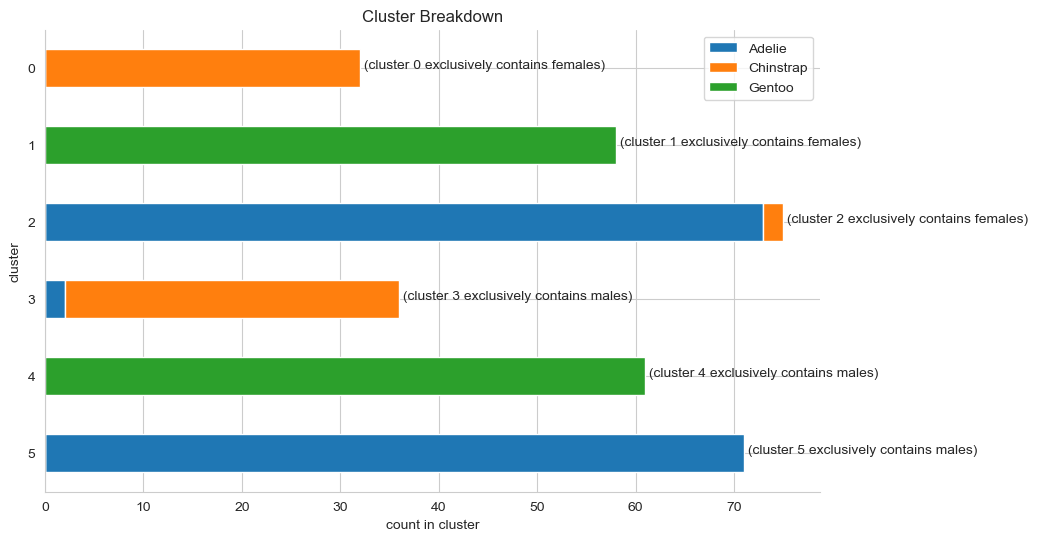

In [41]:
# plot the cluster breakdown
fig, ax = plt.subplots(figsize=(10,6))
penguins_subset_grpd_labeled.plot(kind='barh', stacked=True, title='Cluster Breakdown', ax=ax).invert_yaxis()

# manually sum and label since some topmost segments are missing
for x, y in enumerate(penguins_subset_grpd_labeled.sum(numeric_only = True, axis=1)):
    y = int(y)
    label = penguins_subset_grpd_labeled.loc[x, 'label']
    ax.annotate(label, xy=(y,x))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel("count in cluster")
plt.show()

#### Cluster Attributes

Integrating the cluster characteristics and breakdown analysis allows us to identify these cluster profiles:

- Cluster 0: Penguins with medium-sized bill lengths, medium-sized bill depths, shorter flipper lengths, and less body mass.  This cluster represents female Chinstrap penguins.

- Cluster 1: Penguins with medium-sized bill lengths, shorter bill depths, longer flipper lengths, and more body mass.  This cluster represents female Gentoo penguins.

- Cluster 2: Penguins with shorter bill lengths, medium-sized bill depths, shorter flipper lengths, and less body mass.  This cluster represents mostly Adelie penguins, of which all are female.

- Cluster 3: Penguins with longer bill lengths, longer bill depths, medium-sized flipper lengths, and average body mass.  This cluster represents mostly Chinstrap penguins, of which all are male.

- Cluster 4: Penguins with longer bill lengths, shorter bill depths, longer flipper lengths, and more body mass. This cluster represents male Gentoo penguins.

- Cluster 5: Penguins with shorter bill lengths, longer bill depths, shorter flipper lengths, and average body mass.  This cluster represents male Adelie penguins.

### Utilizing cluster partitions for quantitative analysis

Boxplots provide a quantitative comparison of each trait across different species and sexes:

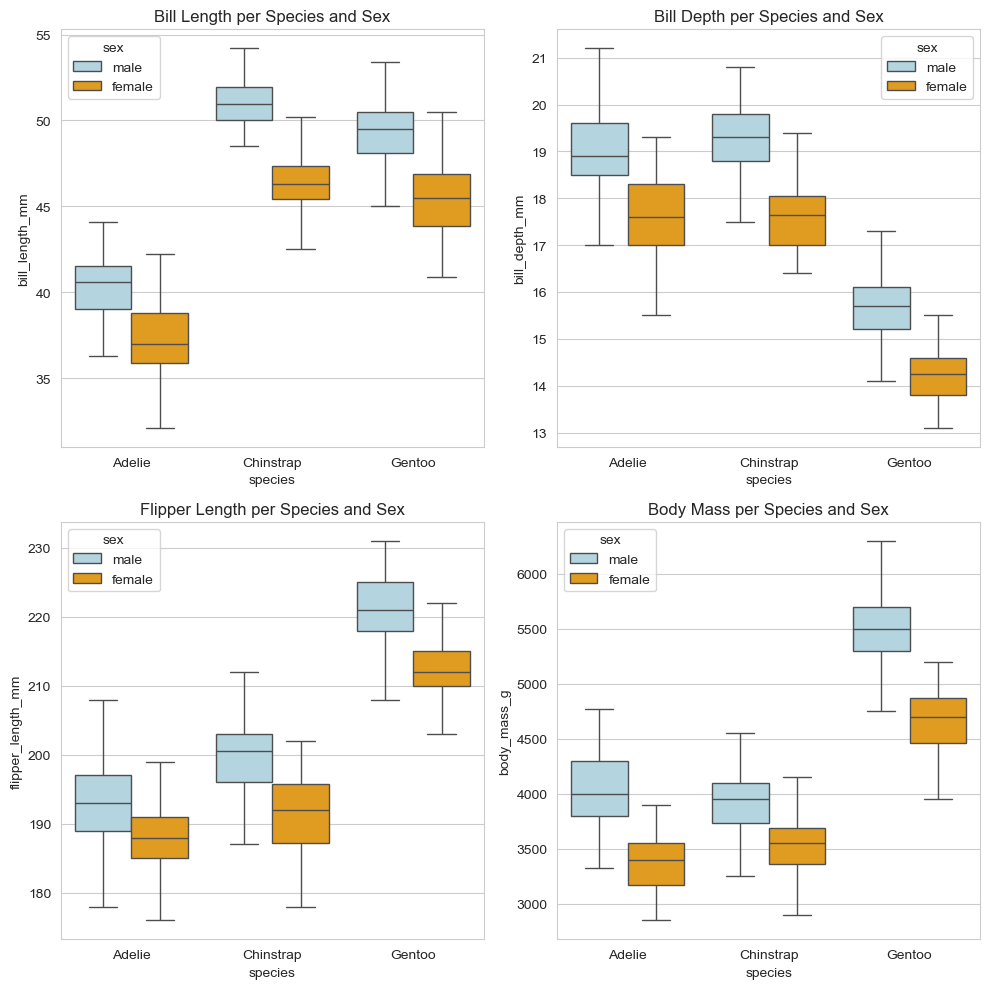

In [42]:
# Boxplots for Bill Length per species and sex
fig, axs = plt.subplots(2, 2, figsize=(10,10))
sns.boxplot(data=penguins, y='bill_length_mm', x='species', hue='sex', ax=axs[0, 0], palette={"male": "lightblue", "female": "orange"}, showfliers=False)
axs[0, 0].set_title('Bill Length per Species and Sex')
sns.boxplot(data=penguins, y='bill_depth_mm', x='species', hue='sex', ax=axs[0, 1], palette={"male": "lightblue", "female": "orange"}, showfliers=False)
axs[0, 1].set_title('Bill Depth per Species and Sex')
sns.boxplot(data=penguins, y='flipper_length_mm', x='species', hue='sex', ax=axs[1, 0], palette={"male": "lightblue", "female": "orange"}, showfliers=False)
axs[1, 0].set_title('Flipper Length per Species and Sex')
sns.boxplot(data=penguins, y='body_mass_g', x='species', hue='sex', ax=axs[1, 1], palette={"male": "lightblue", "female": "orange"}, showfliers=False)
axs[1, 1].set_title('Body Mass per Species and Sex')

plt.tight_layout()
plt.show()

## **Part 4:** Conclusion

K-means clustering effectively partitioned the penguins dataset into distinct groups, revealing that penguins of the same species do exhibit different physical characteristics based on sex.
- The optimal number of clusters, determined through inertia and silhouette analysis, was found to be six.
- The elbow plot, complemented by silhouette scores, supported this decision.
- Subsequent analysis demonstrated that these clusters are primarily characterized by species and sex, as evident in the groupby results and corresponding visualizations.
- Utilizing the cluster partitions, a quantitative boxplot graphic was constructed to illustrate key attributes.

**Key Cluster Findings:**
- Sex-Based Clustering: The clusters primarily differentiate between male and female penguins.
- Species-Based Clustering: Within each sex, there is further differentiation based on species.
- Physical Attributes: Bill length, bill depth, flipper length, and body mass are key factors in determining cluster membership.

**Cluster Attribute Summary:**
- Female Clusters: Characterized by smaller body size, shorter flippers, and generally smaller bill dimensions.
  - Chinstrap females: Medium-sized bills (largest amongst the females).
  - Gentoo females: Shorter bill depths, longer flippers.
  - Adelie females: Smallest overall size.

- Male Clusters: Characterized by larger body size, longer flippers, and generally larger bill dimensions.
  - Chinstrap males: Larger bills coverall.
  - Gentoo males: Largest overall size.
  - Adelie males: Smallest flippers compared to other males.